# Active site analysis

# Imports

In [1]:
import MDAnalysis as mda
import MDAnalysis.analysis.distances
import BioSimSpace as bss
import numpy as np
import nglview as nv
import os
import matplotlib.pyplot as plt


<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.



Sending anonymous Sire usage statistics to http://siremol.org.
For more information, see http://siremol.org/analytics
To disable, set the environment variable 'SIRE_DONT_PHONEHOME' to 1
To see the information sent, set the environment variable 
SIRE_VERBOSE_PHONEHOME equal to 1. To silence this message, set
the environment variable SIRE_SILENT_PHONEHOME to 1.



# Functions

In [3]:
def get_universe(file_path: str) -> tuple:
    """
    get PARM7, DCD files and return universe
    """
    topology = file_path + "somd.prm7"
    trajectory = file_path + "traj000000002.dcd"
    if not os.path.isfile(trajectory):
        trajectory = file_path + "traj000000001.dcd"
    return mda.Universe(topology, trajectory, topology_format="PARM7")


def get_coumarin_ring(ligand_group: mda.AtomGroup) -> mda.AtomGroup:
    """
    return atom group containing coumarin ring atoms
    """
    coumarin_ring_selection = "name C02 C03 C04 O C06 C08 C09 C15 C C17"
    return ligand_group.select_atoms(coumarin_ring_selection)


def get_indole_rings(protein_group: mda.AtomGroup) -> mda.AtomGroup:
    """
    find tryptophan 82 and return its rings as an atom group
    """
    tryptophan = protein_group.select_atoms("resname TRP and resid 82")
    indole_ring_selection = "name CG CD1 NE1 CE2 CZ2 CH2 CZ3 CE3 CD2"
    return tryptophan.select_atoms(indole_ring_selection)


def get_pyrrole_ring(indole_ring_group: mda.AtomGroup) -> mda.AtomGroup:
    pyrrole_ring_selections = "name CD1 CG CD2 CE2 NE1"
    return indole_ring_group.select_atoms(pyrrole_ring_selections)


def get_lactone_ring(coumarin_ring_group: mda.AtomGroup) -> mda.AtomGroup:
    """
    return lactone part of coumarin ring
    """
    lactone_ring_selections = "name C04 O C06 C08 C09 C15"
    return coumarin_ring_group.select_atoms(lactone_ring_selections)


def get_benzene_ring(reference_group: mda.AtomGroup, selection: str) -> mda.AtomGroup:
    """
    take a bicyclic atom group and select its benzene ring
    """
    return reference_group.select_atoms(selection)


# Get all data

In [80]:
ligand_indices_all = np.arange(2, 17, 1)
ligand_indices = np.delete(ligand_indices_all, [10, 12, 13])
ligand_data = []
tryptophan_data = []
trajectories = []
hydrogen_bond_data = []
for i in ligand_indices:
    path = f"../outputs/SOMD/lig_h_1~lig_h_{i}/bound/lambda_1.0000/"
    print(path)
    universe = get_universe(path)
    trajectory = universe.trajectory
    trajectories.append(trajectory)
    times = [frame.time for frame in trajectory]

    protein = universe.select_atoms("protein")
    indole_ring = get_indole_rings(protein)
    pyrrole_ring = get_pyrrole_ring(indole_ring)
    indole_benzene_selection = "name CH2 CZ2 CE2 CD2 CE3 CZ3"
    indole_benzene = get_benzene_ring(indole_ring, indole_benzene_selection)
    tryptophan_data.append((times, indole_ring, pyrrole_ring, indole_benzene))
    
    ligand = universe.select_atoms("resname LIG")
    coumarin_ring = get_coumarin_ring(ligand)
    lactone_ring = get_lactone_ring(coumarin_ring)
    coumarin_benzene_selection = "name C02 C03 C04 C15 C C17"
    coumarin_benzene = get_benzene_ring(coumarin_ring, coumarin_benzene_selection)
    ligand_data.append((times, coumarin_ring, lactone_ring, coumarin_benzene))

    hydrogen_bond_data.append((times, protein, ligand))

    

../outputs/SOMD/lig_h_1~lig_h_2/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_3/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_4/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_5/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_6/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_7/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_8/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_9/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_10/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_11/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_13/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_14/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_15/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_16/bound/lambda_1.0000/


# Centroid distances between coumarin and indole

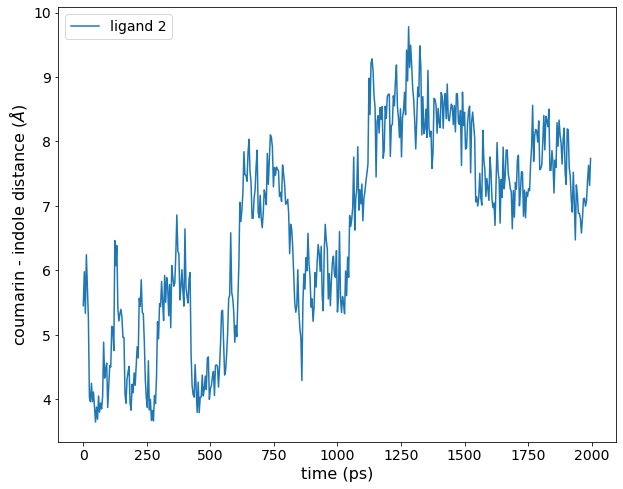

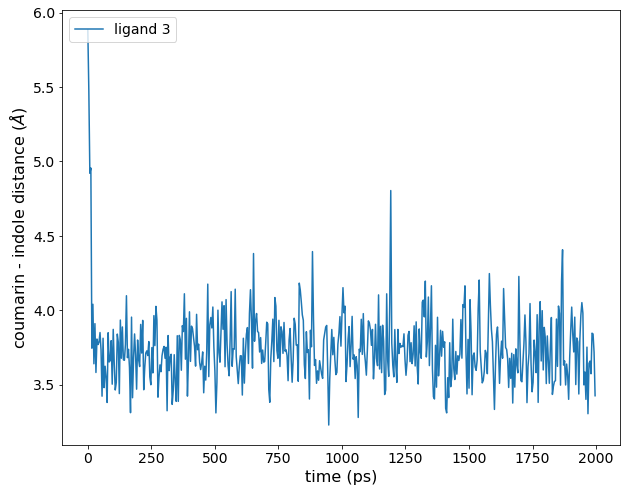

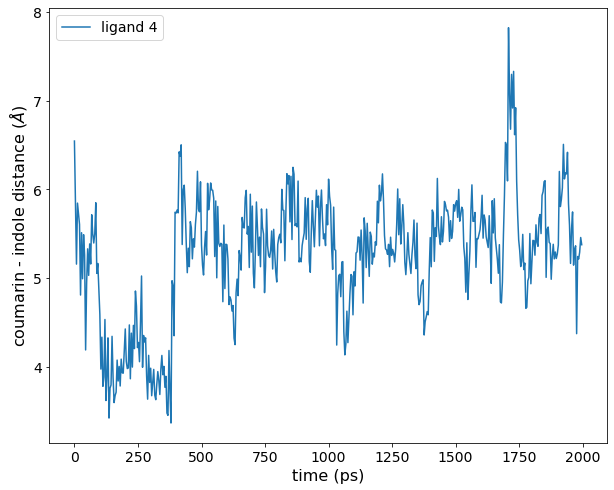

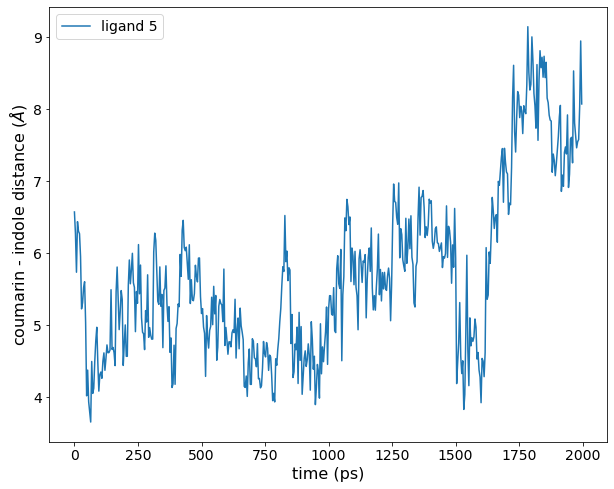

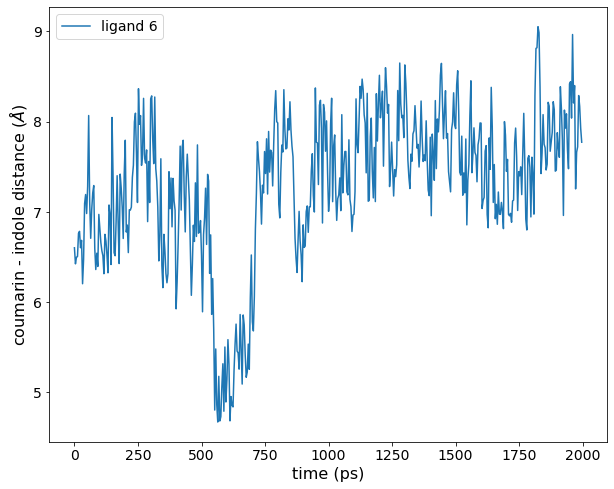

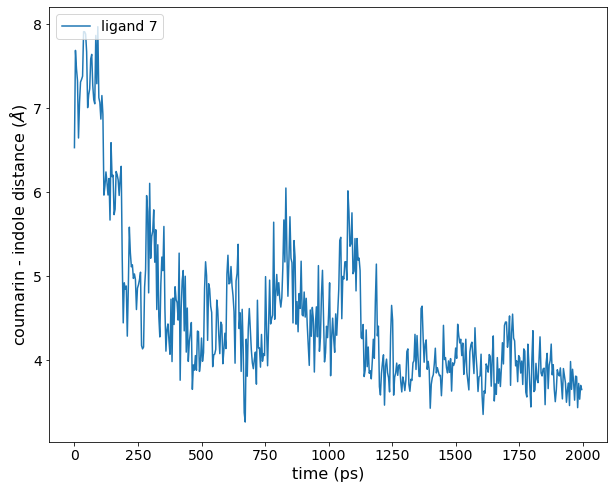

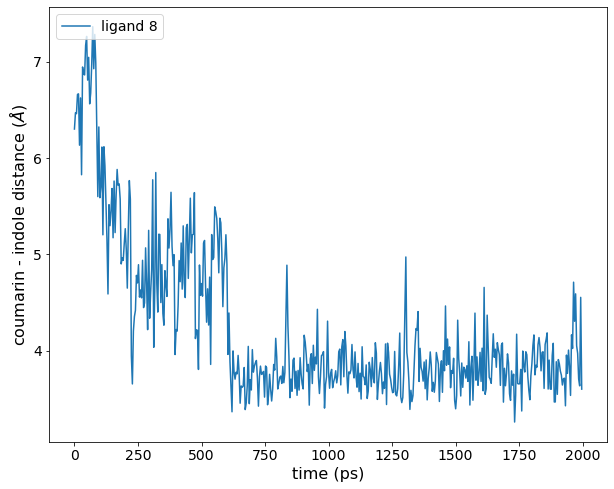

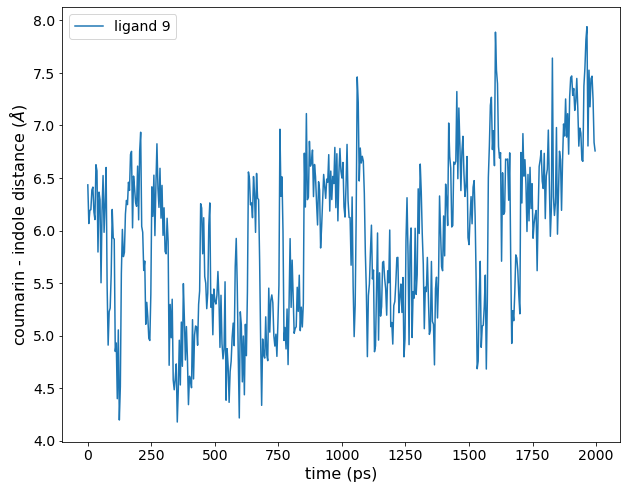

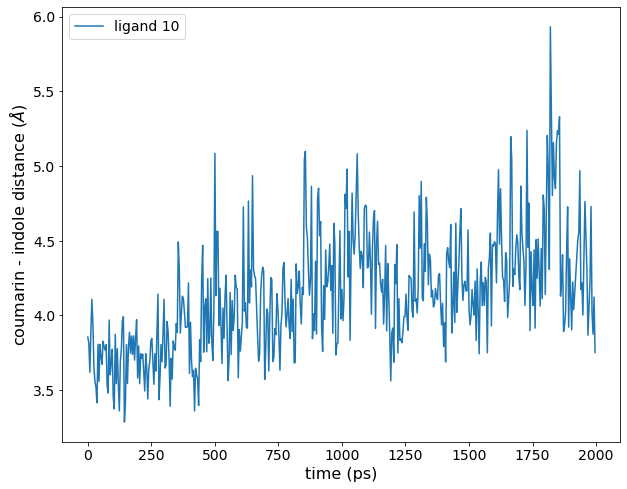

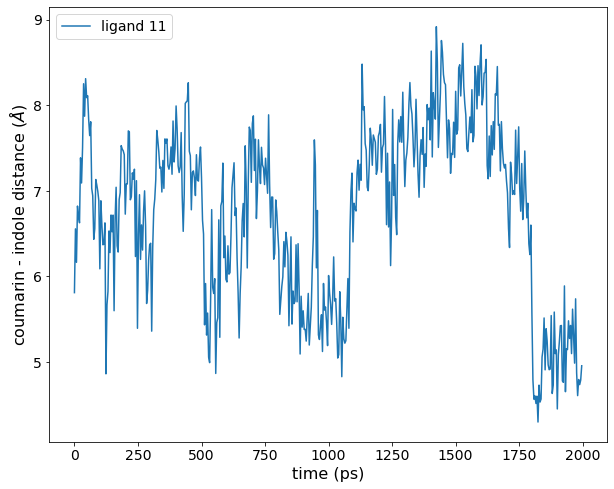

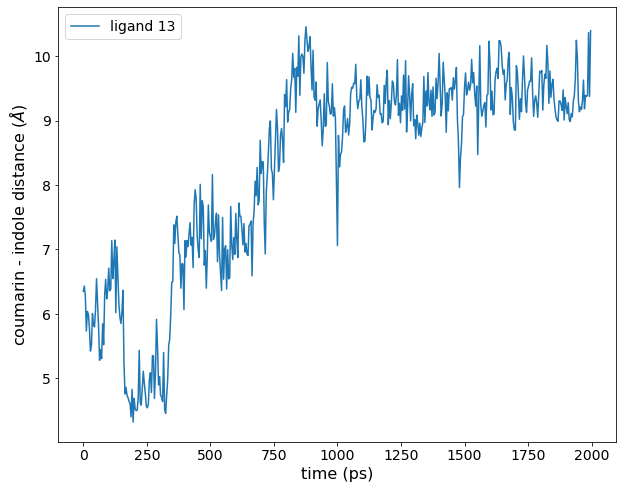

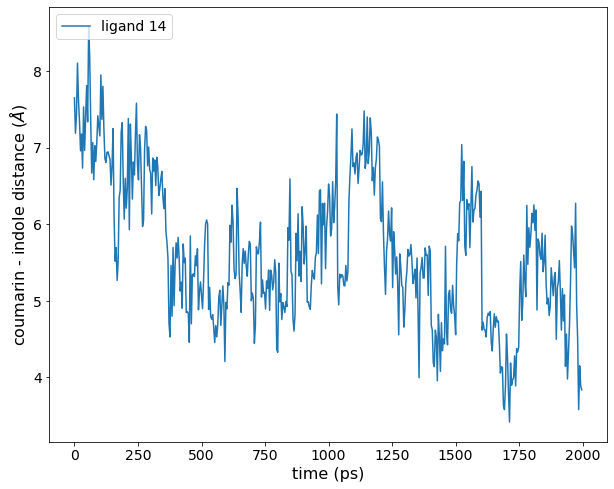

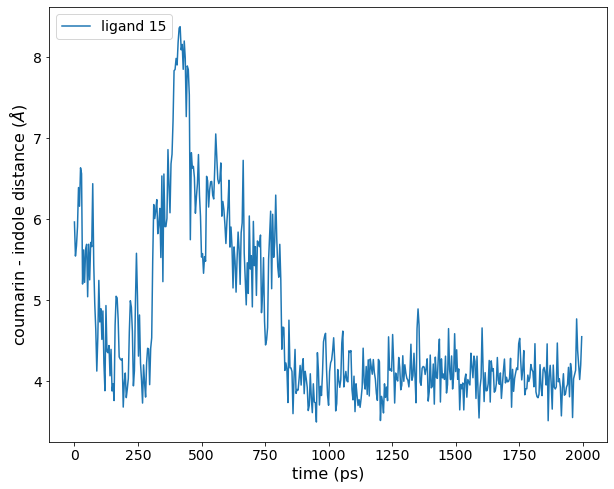

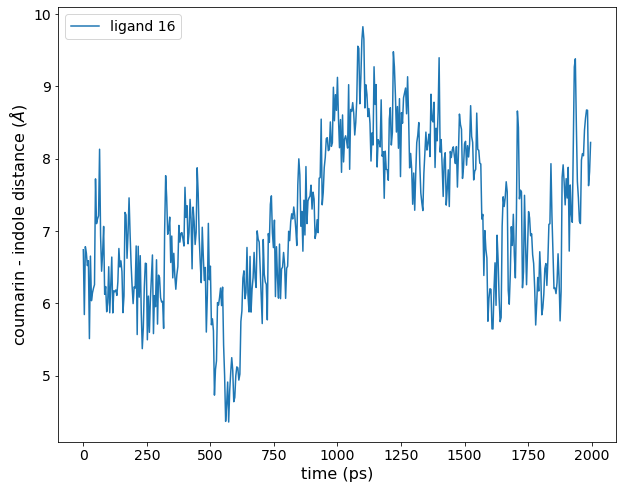

In [55]:
for i in range(len(trajectories)):
    coumarin_indole_distances = []
    coumarin_centroids = []
    indole_centroids = []
    for frame in trajectories[i]:
        times = ligand_data[i][0]
        coumarin_ring = ligand_data[i][1]
        lactone_ring = ligand_data[i][2]
        coumarin_benzene = ligand_data[i][3]
        indole_ring = tryptophan_data[i][1]
        pyrrole_ring = tryptophan_data[i][2]
        indole_benzene = tryptophan_data[i][2]
        coumarin_centroid = coumarin_ring.centroid()
        indole_centroid = indole_ring.centroid()
        coumarin_indole_distance = mda.analysis.distances.distance_array(coumarin_centroid, indole_centroid)
        coumarin_indole_distances.append((frame.time, coumarin_indole_distance[0][0]))
        coumarin_centroids.append((frame.time, coumarin_centroid[0]))
        indole_centroids.append((frame.time, indole_centroid[0]))
    coumarin_indole_distances = np.asarray(coumarin_indole_distances)
    coumarin_centroids = np.asarray(coumarin_centroids)
    indole_centroids = np.asarray(indole_centroids)

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    ax.plot(coumarin_indole_distances[:,0], coumarin_indole_distances[:,1], label=f"ligand {ligand_indices[i]}")
    # ax[0].set_title("coumarin - indole centroid")
    # ax[1].scatter(coumarin_centroids[:,1], indole_centroids[:,1], label=f"ligand {ligand_indices[i]}")
    # ax[1].set_title("centroids")
    # ax[1].set_ylabel("indole")
    # ax[1].set_xlabel("coumarin")
    # ax[2].plot(indole_centroids[:,0], indole_centroids[:,1], label=f"ligand {ligand_indices[i]}")
    # ax[2].set_title("indole centroid coordinates")
    ax.set_xlabel("time (ps)")
    ax.set_ylabel(r"coumarin - indole distance ($\AA$)")
    ax.legend(loc="upper left")
    # ax[1].legend()
    # ax[2].legend()
    # plt.show()
    


# Ring centroid distances 

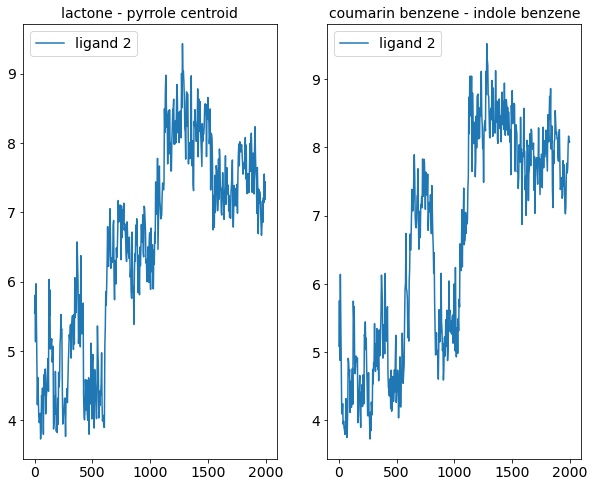

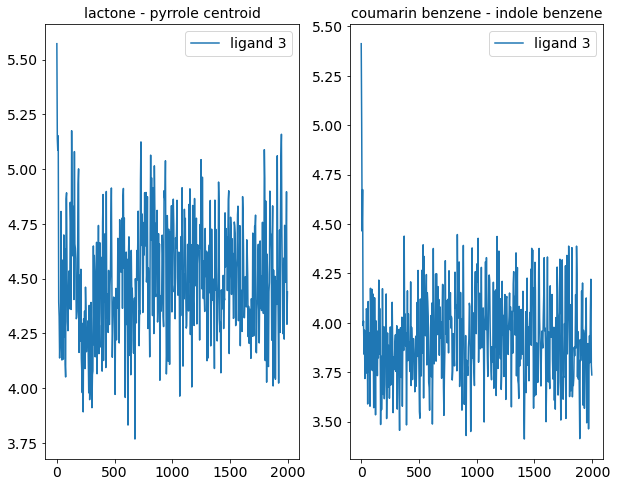

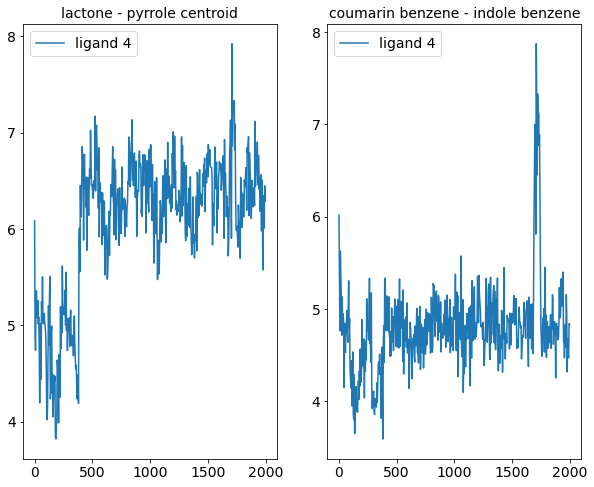

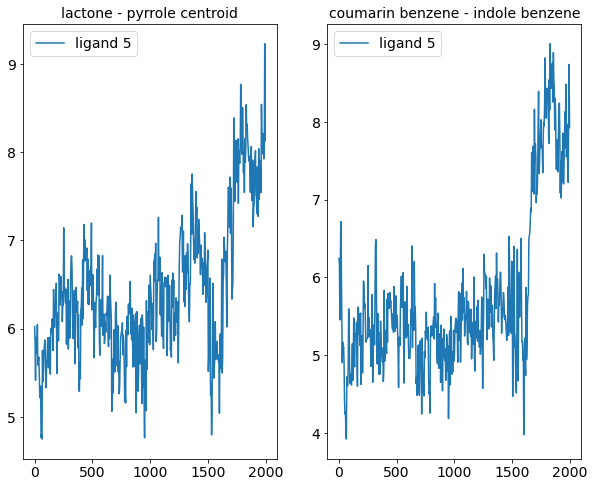

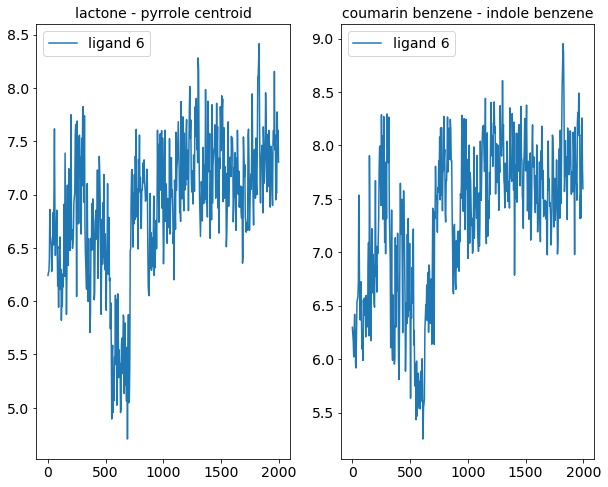

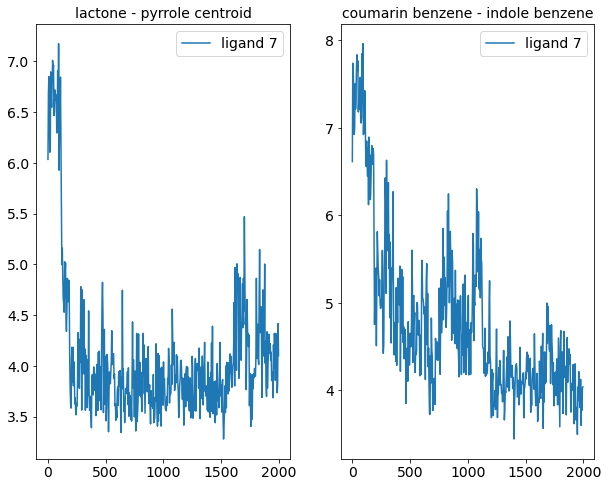

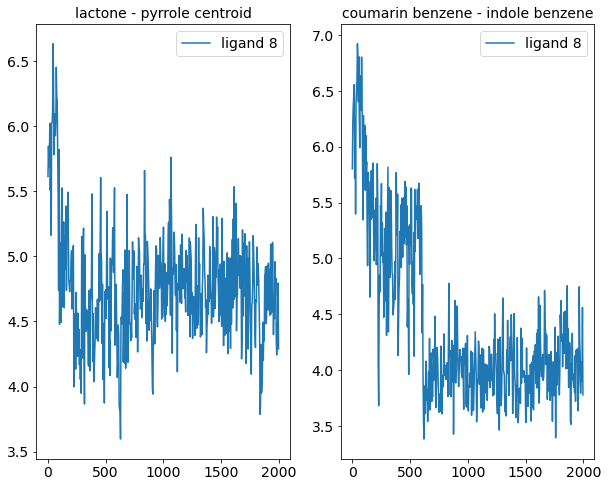

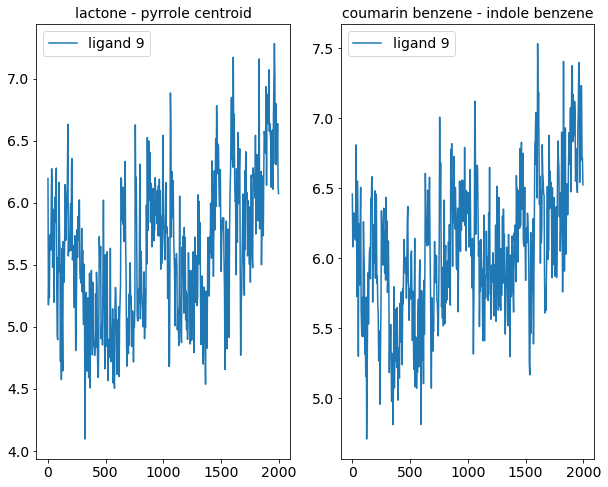

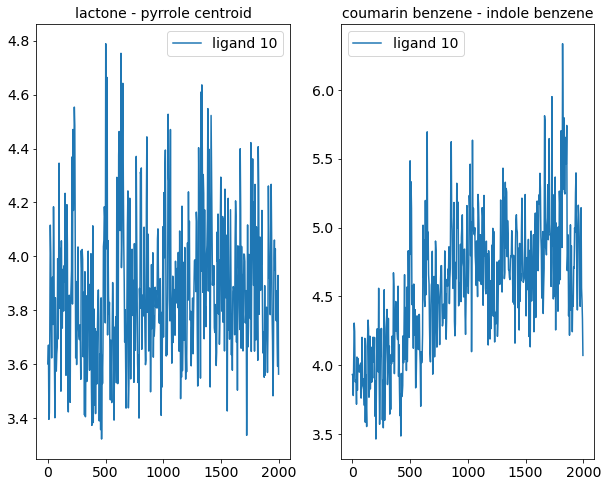

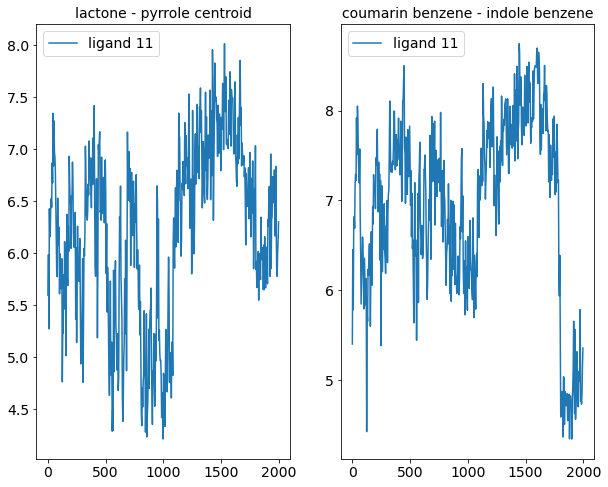

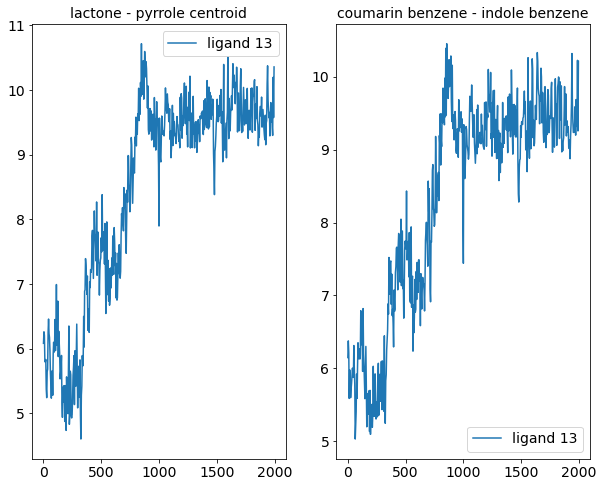

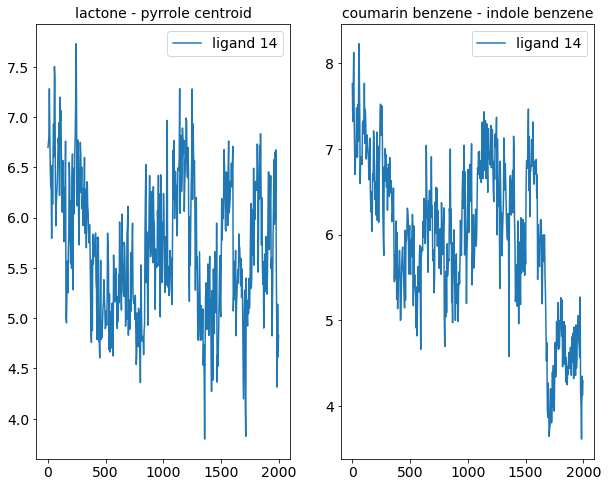

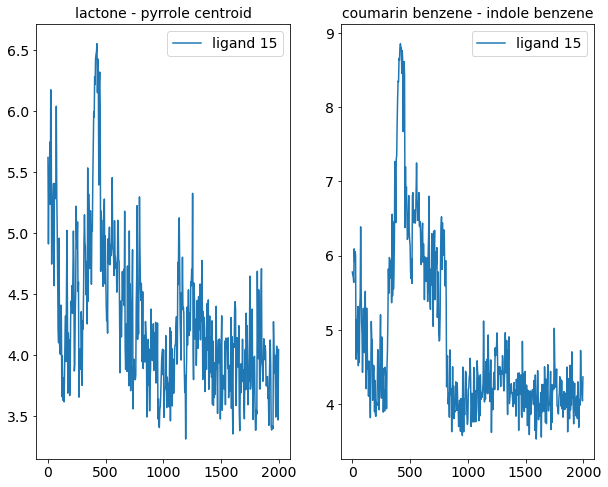

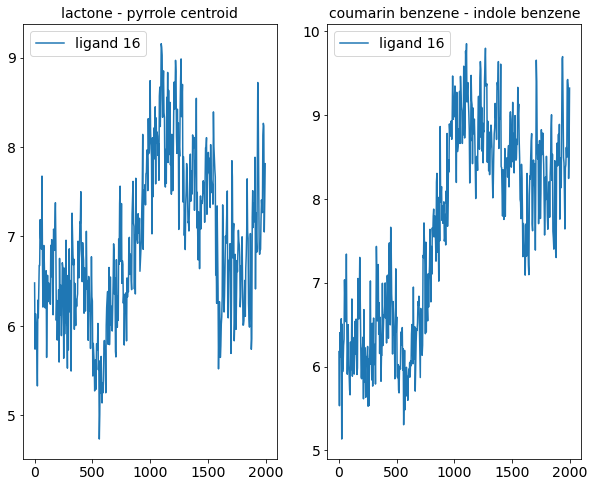

In [56]:
for i in range(len(trajectories)):
    lactone_pyrrole_distances = []
    bb_distances = []
    for frame in trajectories[i]:
        times = ligand_data[i][0]
        lactone_ring = ligand_data[i][2]
        coumarin_benzene = ligand_data[i][3]
        pyrrole_ring = tryptophan_data[i][2]
        indole_benzene = tryptophan_data[i][2]

        lactone_centroid = lactone_ring.centroid()
        pyrrole_centroid = pyrrole_ring.centroid()
        coumarin_b_centroid = coumarin_benzene.centroid()
        indole_b_centroid = indole_benzene.centroid()
        
        lactone_pyrrole_distance = mda.analysis.distances.distance_array(lactone_centroid, pyrrole_centroid)
        lactone_pyrrole_distances.append((frame.time, lactone_pyrrole_distance[0][0]))

        bb_distance = mda.analysis.distances.distance_array(coumarin_b_centroid, indole_b_centroid)
        bb_distances.append((frame.time, bb_distance[0][0]))
        
    lactone_pyrrole_distances = np.asarray(lactone_pyrrole_distances)
    bb_distances = np.asarray(bb_distances)

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10, 8)
    ax[0].plot(lactone_pyrrole_distances[:,0], lactone_pyrrole_distances[:,1], label=f"ligand {ligand_indices[i]}")
    ax[0].set_title("lactone - pyrrole centroid")
    ax[1].plot(bb_distances[:,0], bb_distances[:,1], label=f"ligand {ligand_indices[i]}")
    ax[1].set_title("coumarin benzene - indole benzene")
    # ax[2].plot(indole_centroids[:,0], indole_centroids[:,1], label=f"ligand {ligand_indices[i]}")
    # ax[2].set_title("indole centroid coordinates")
    ax[0].legend()
    ax[1].legend()
    # ax[2].legend()
    plt.show()
    


# Carbonyl oxygen distance from HIS274 & ARG220

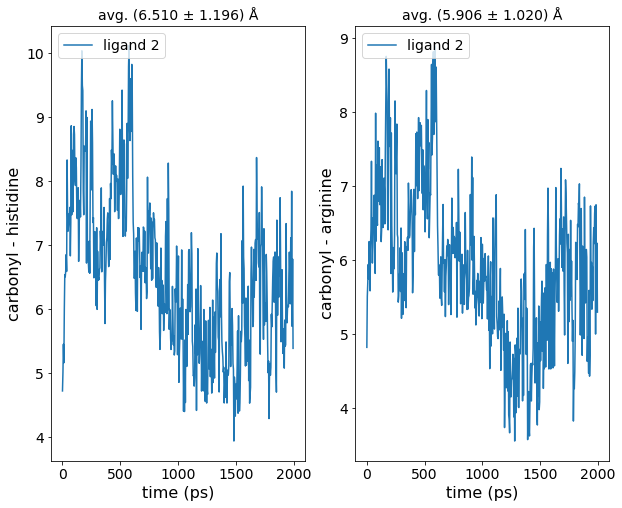

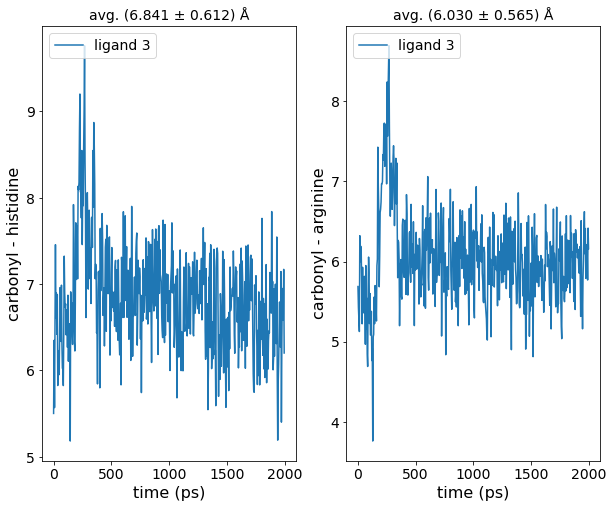

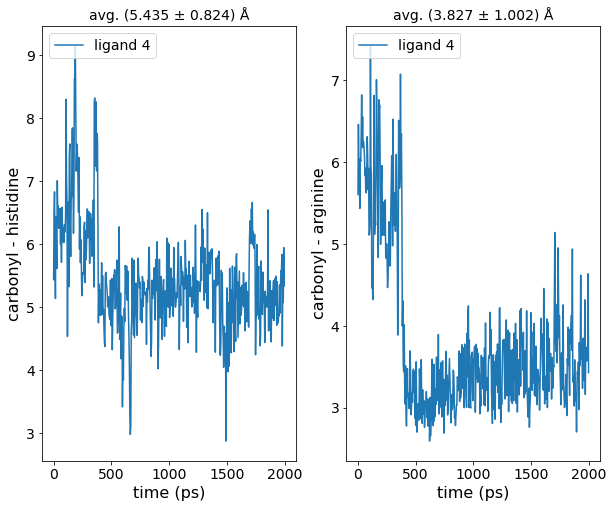

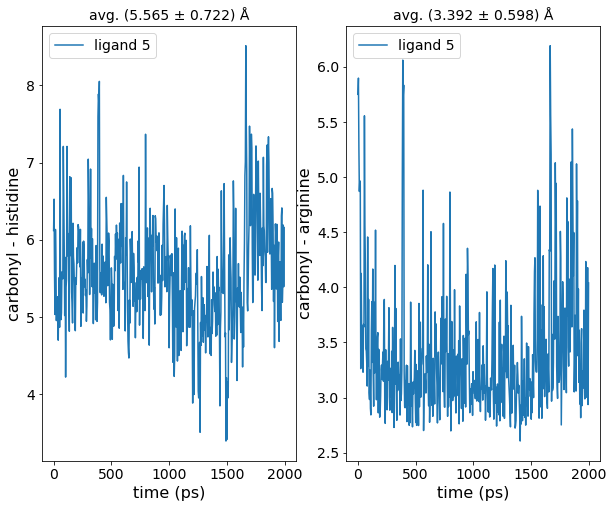

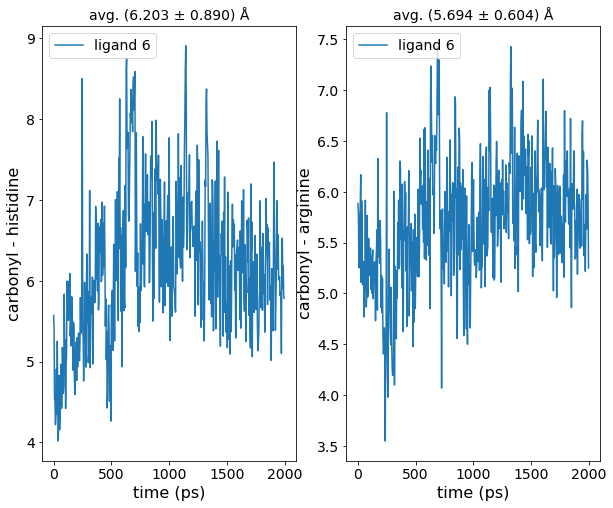

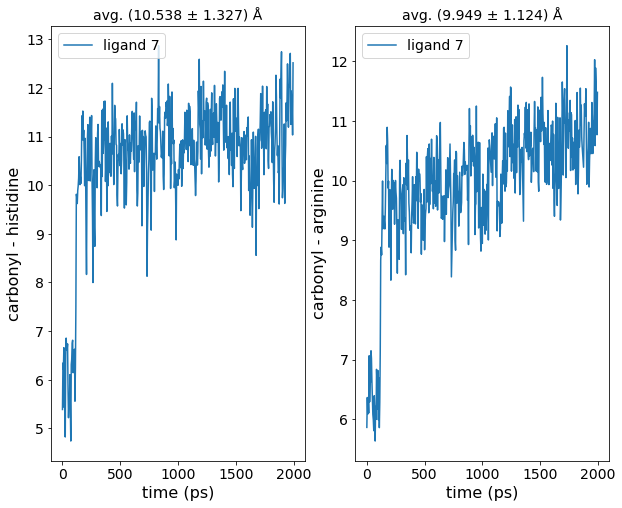

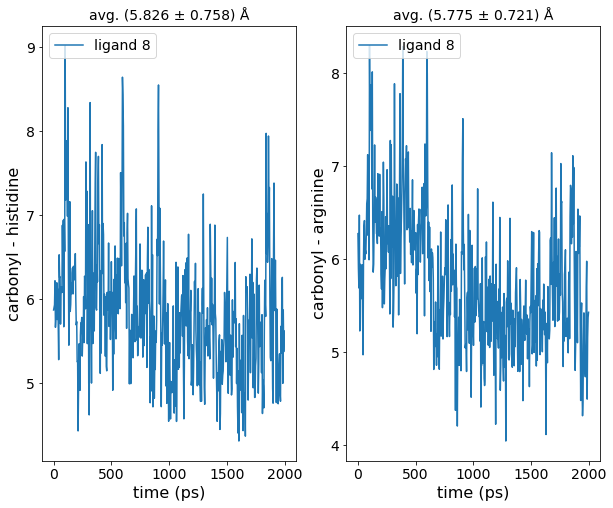

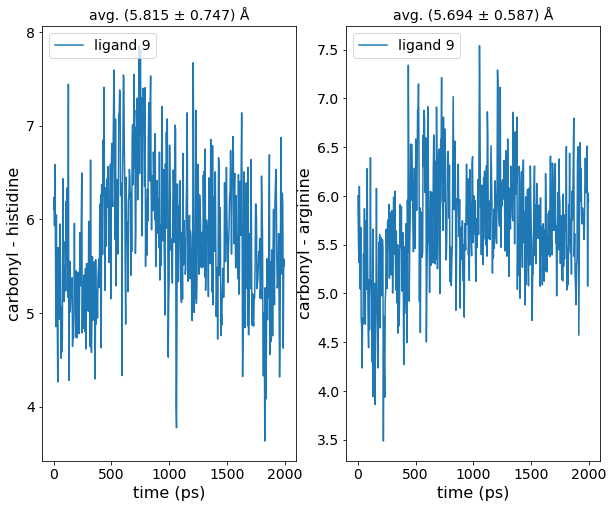

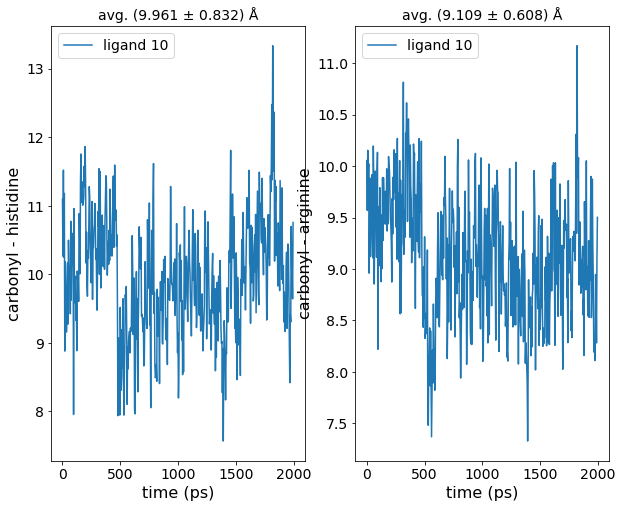

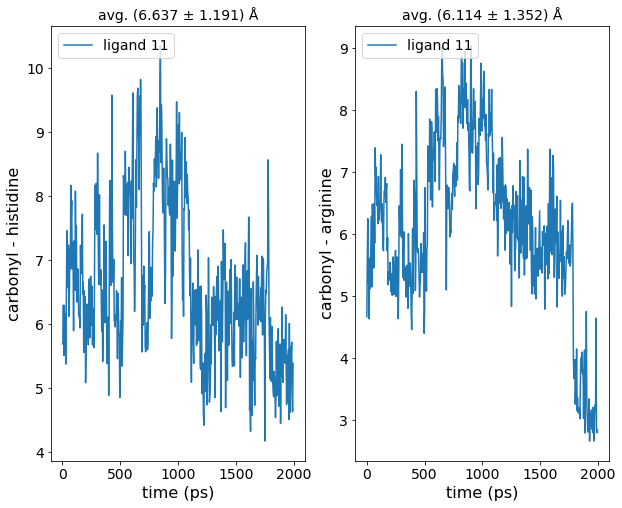

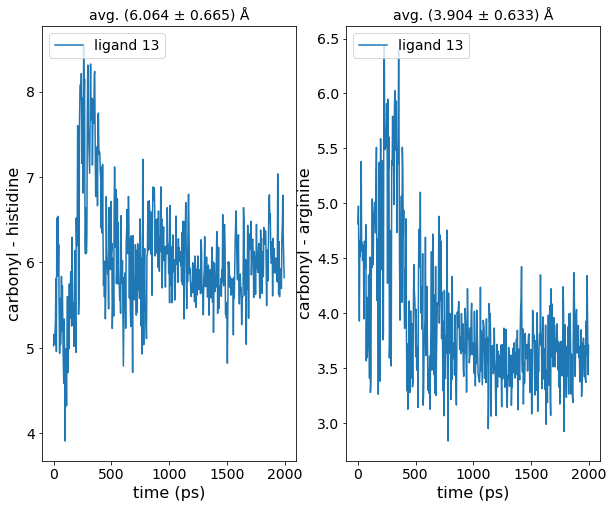

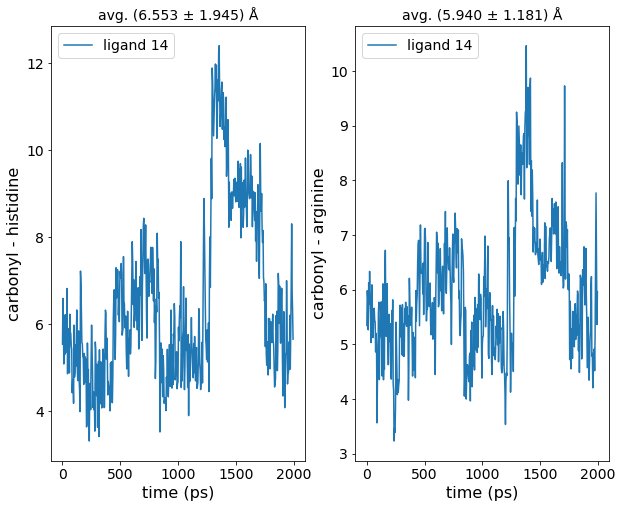

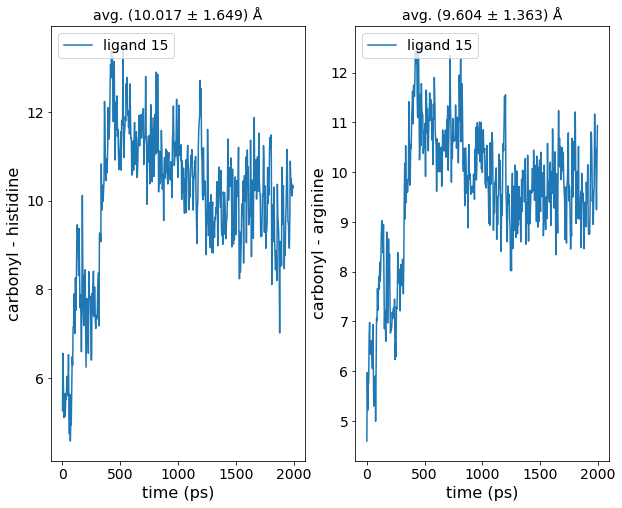

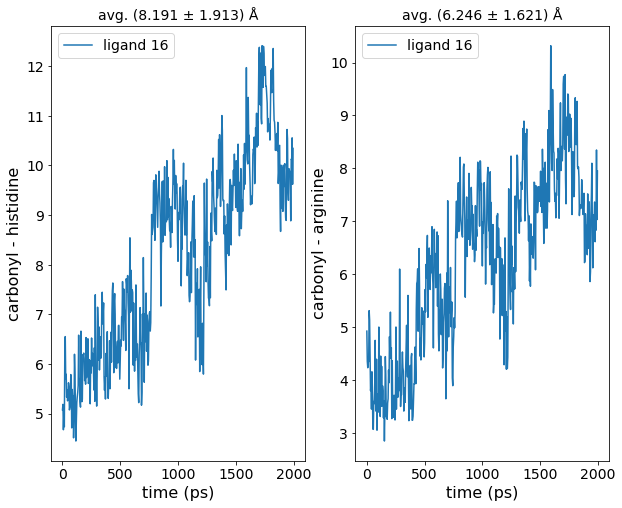

In [91]:
for i in range(len(trajectories)):
    histidine_distances = []
    arginine_distances = []
    for frame in trajectories[i]:
        time = hydrogen_bond_data[i][0]
        arginine = hydrogen_bond_data[i][1].select_atoms("resid 197")
        histidine = hydrogen_bond_data[i][1].select_atoms("resid 250")
        ligand = hydrogen_bond_data[i][2]
        arginine_nitrogen = arginine.select_atoms("name NH2").center_of_mass()
        histidine_nitrogen = histidine.select_atoms("name NE2").center_of_mass()
        carbonyl_oxygen = ligand.select_atoms("name O1").center_of_mass()

        histidine_distance = mda.analysis.distances.distance_array(carbonyl_oxygen, histidine_nitrogen)
        arginine_distance = mda.analysis.distances.distance_array(carbonyl_oxygen, arginine_nitrogen)

        histidine_distances.append((frame.time, histidine_distance[0][0]))
        arginine_distances.append((frame.time, arginine_distance[0][0]))
    histidine_distances = np.asarray(histidine_distances)
    arginine_distances = np.asarray(arginine_distances)

    mean_his_distance = np.mean(histidine_distances[:,1])
    std_his_distance = np.std(histidine_distances[:,1])
    mean_arg_distance = np.mean(arginine_distances[:,1])
    std_arg_distance = np.std(arginine_distances[:,1])

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10, 8)
    ax[0].plot(histidine_distances[:,0], histidine_distances[:,1], label=f"ligand {ligand_indices[i]}")
    ax[1].plot(arginine_distances[:,0], arginine_distances[:,1], label=f"ligand {ligand_indices[i]}")
    ax[0].set_xlabel("time (ps)")
    ax[0].set_ylabel("carbonyl - histidine")
    ax[1].set_ylabel("carbonyl - arginine")
    ax[1].set_xlabel("time (ps)")

    ax[0].set_title(f"avg. ({mean_his_distance:.3f} \u00B1 {std_his_distance:.3f}) \u212B")
    ax[1].set_title(f"avg. ({mean_arg_distance:.3f} \u00B1 {std_arg_distance:.3f}) \u212B")

    ax[0].legend(loc="upper left")
    ax[1].legend(loc="upper left")
    plt.show()

In [95]:
ligand = hydrogen_bond_data[-3][2]

In [96]:
nv.show_mdanalysis(ligand)

NGLWidget(max_frame=499)

In [75]:
nv.show_mdanalysis(arginine)

NGLWidget(max_frame=499)

In [76]:
nv.show_mdanalysis(histidine)

NGLWidget(max_frame=499)